In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time
import pickle
import json
import torch
import numpy as np
from pyg_data import queryPlanPGDataset_withbenchmark
from util.util import set_seed, load_model_params
from util.data_transform import *
from util.custom_loss import aleatoric_loss, rmse_loss, bce_loss
import pytorch_lightning as pl
from lcm.roq_model import lcm_pl as roq_model
from lcm.neo_bao_model import lcm_pl as neo_bao_model
from lcm.lero_model import LeroModelPairwise as leroPairwise
from lcm.balsa_model import balsa_simulation, balsa_model
from sklearn.model_selection import KFold,train_test_split
from single_test_lero import test
from util.eval_util import *
from torch_geometric.loader import DataLoader

/database/config/db2inst1/.venv/lib/python3.10/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /database/config/db2inst1/.venv/lib/python3.10/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/database/config/db2inst1/.venv/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /database/config/db2inst1/.venv/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/database/config/db2inst1/.venv/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /database/config/db

In [2]:
models_path = os.path.join('.','lightning_models')
results_dir = os.path.join('.','results')

In [3]:
arch = 'roq'
experiment_id = 'job_v2.2'
files_id = 'job_v2.2'
benchmark_files_id = 'job_v2.2'
labeled_data_dir = '../labeled_data/job/'
max_epochs = 1000
patience = 100
num_workers = 10
seed = 313
reload_data = True
target = 'latency' 
test_split = 'test'
val_samples = 0.1
test_samples = 0.1
test_slow_samples = 0.5

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# sets seed for random, numpy, and torch cuda  
set_seed(seed)

torch.set_float32_matmul_precision('high')

# Load train,v alidation, and test datasets
print("loading train")
train_set = queryPlanPGDataset_withbenchmark(
    split= 'train', files_id = files_id,
    benchmark_files_id=benchmark_files_id,
    labeled_data_dir=labeled_data_dir,  
    force_reload=reload_data, seed = seed,
    val_samples = val_samples, 
    test_samples = test_samples,
    test_slow_samples = test_slow_samples,
    exp_id=experiment_id
    )
print("{} queries and {} samples in training dataset: ".format(np.unique(np.array(train_set.query_id)).shape[0],train_set.len()))

print("loading val")
val_set = queryPlanPGDataset_withbenchmark(
    split= 'val', 
    files_id = files_id,
    exp_id=experiment_id
    )
print("{} queries and {} samples in vlidation dataset: ".format(np.unique(np.array(val_set.query_id)).shape[0],val_set.len()))

print("loading test")
test_set = queryPlanPGDataset_withbenchmark(
    split= test_split, 
    files_id = files_id,
    exp_id=experiment_id
    )
print("{} queries and {} samples in test dataset: ".format(np.unique(np.array(test_set.query_id)).shape[0],test_set.len()))

Loading the data ... 100%
long_running_queries 6
test_long_run_qids 3
remaining_test_samples 8
92 queries and 2392 samples in training dataset: 
loading val
11 queries and 286 samples in vlidation dataset: 
loading test
10 queries and 260 samples in test dataset: 


Done!


In [5]:
null_imp = nullImputation(train_set)
train_set = null_imp(train_set)
val_set = null_imp(val_set)
test_set = null_imp(test_set)

minmax_scale = minmaxScale(train_set)
train_set = minmax_scale(train_set)
val_set = minmax_scale(val_set)
test_set = minmax_scale(test_set)

# if arch != 'lero':
# Perform data transformations on targets 
yTransFunc = target_log_transform(train_set, target = target)

train_set = yTransFunc.transform(train_set)
val_set = yTransFunc.transform(val_set)
test_set = yTransFunc.transform(test_set)

plan_attr_shape = train_set[0].plan_attr.shape
plan_ord_shape = train_set[0].plan_ord.shape
graph_attr_shape= train_set[0].graph_attr.shape
edge_attr_shape = train_set[0].edge_attr_s.shape
node_attr_shape = train_set[0].x_s.shape

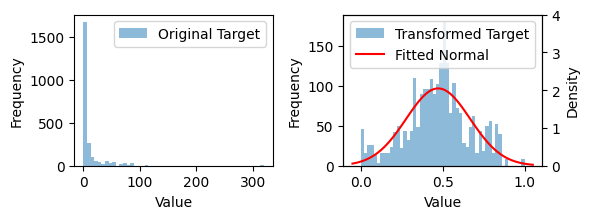

In [6]:
# original target: train_set.y
# transformed target: train_set.y_t
# crate a histogram that displays the distribution of the original target and the transformed target side by side in two subplots and allows customization of figure size and title
# the second histogram is fitted with a normal distribution bell curve

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.3))

# First subplot remains unchanged
ax1.hist(train_set.y, bins=50, alpha=0.5, label='Original Target')
# ax1.set_title('Original Target')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.legend()

# Second subplot: plot the frequency histogram on ax2 (left y-axis)
ax2.hist(train_set.y_t, bins=50, alpha=0.5, label='Transformed Target', color='C0')
# ax2.set_title('Transformed Target')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')

# Create a twin axis for density (right y-axis)
ax2_density = ax2.twinx()

# Fit a normal distribution to the transformed data
mu, std = train_set.y_t.mean(), train_set.y_t.std()
xmin, xmax = ax2.get_xlim()
x = np.linspace(xmin, xmax, 100)
pdf = stats.norm.pdf(x, mu, std)

# Plot the fitted normal density curve on the twin axis
ax2_density.plot(x, pdf, 'r-', label='Fitted Normal')
ax2_density.set_ylabel('Density')
ax2_density.set_ylim(0,4)

# Combine legends from both axes
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_density.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('./plots/target_transformation.png',bbox_inches='tight',dpi=300)
plt.show()



Shapiro–Wilk test statistic: 0.986, p-value: 0.000
Interpretation (Shapiro–Wilk): p < 0.05, so we reject the null hypothesis of normality. The data does not follow a normal distribution.

Lilliefors (K-S) test statistic: 0.040, p-value: 0.001
Interpretation (Lilliefors): p < 0.05, so we reject the null hypothesis of normality. The data does not follow a normal distribution.

Anderson–Darling test statistic: 8.602
Critical values and significance levels:
  At 15.0% significance, critical value: 0.575
  At 10.0% significance, critical value: 0.655
  At 5.0% significance, critical value: 0.786
  At 2.5% significance, critical value: 0.916
  At 1.0% significance, critical value: 1.090
Interpretation (Anderson–Darling): The test statistic is greater than the 1% critical value, so we reject normality. The data does not follow a normal distribution.

Jarque–Bera test statistic: 9.372, p-value: 0.009
Interpretation (Jarque–Bera): p < 0.05, so we reject the null hypothesis of normality. The dat

/tmp/ipykernel_26907/1054858543.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(train_set.y_t)


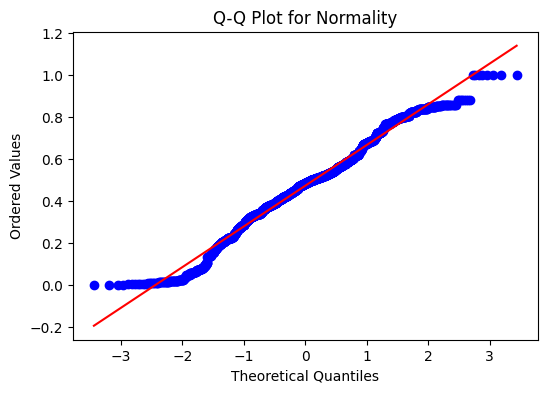

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors

# Read the dataset (update filename and column name as needed)
x = np.array(train_set.y_t)

# 1. Shapiro–Wilk Test
stat_shapiro, p_shapiro = stats.shapiro(x)
print(f"Shapiro–Wilk test statistic: {stat_shapiro:.3f}, p-value: {p_shapiro:.3f}")
if p_shapiro < 0.05:
    print("Interpretation (Shapiro–Wilk): p < 0.05, so we reject the null hypothesis of normality. The data does not follow a normal distribution.")
else:
    print("Interpretation (Shapiro–Wilk): p ≥ 0.05, so we cannot reject the null hypothesis. The data may be normally distributed.")

# 2. Lilliefors Test (a version of the K-S test adjusted for estimated parameters)
stat_lilliefors, p_lilliefors = lilliefors(x)
print(f"\nLilliefors (K-S) test statistic: {stat_lilliefors:.3f}, p-value: {p_lilliefors:.3f}")
if p_lilliefors < 0.05:
    print("Interpretation (Lilliefors): p < 0.05, so we reject the null hypothesis of normality. The data does not follow a normal distribution.")
else:
    print("Interpretation (Lilliefors): p ≥ 0.05, so we cannot reject the null hypothesis. The data may be normally distributed.")

# 3. Anderson–Darling Test
result_ad = stats.anderson(x, dist='norm')
print(f"\nAnderson–Darling test statistic: {result_ad.statistic:.3f}")
print("Critical values and significance levels:")
for cv, sig in zip(result_ad.critical_values, result_ad.significance_level):
    print(f"  At {sig}% significance, critical value: {cv:.3f}")

# For Anderson–Darling, if the test statistic is larger than the critical value at a given significance level, the null hypothesis of normality is rejected.
# Here we compare against the lowest significance level (most strict), which is 1.0% (critical value 1.090 in your output).
if result_ad.statistic > result_ad.critical_values[-1]:
    print("Interpretation (Anderson–Darling): The test statistic is greater than the 1% critical value, so we reject normality. The data does not follow a normal distribution.")
else:
    print("Interpretation (Anderson–Darling): The test statistic is not greater than the 1% critical value, so we cannot reject normality.")

# 4. Jarque–Bera Test
stat_jb, p_jb = stats.jarque_bera(x)
print(f"\nJarque–Bera test statistic: {stat_jb:.3f}, p-value: {p_jb:.3f}")
if p_jb < 0.05:
    print("Interpretation (Jarque–Bera): p < 0.05, so we reject the null hypothesis of normality. The data does not follow a normal distribution.")
else:
    print("Interpretation (Jarque–Bera): p ≥ 0.05, so we cannot reject the null hypothesis. The data may be normally distributed.")

# Q-Q Plot for visual assessment
plt.figure(figsize=(6, 4))
stats.probplot(x, dist="norm", plot=plt)
plt.title("Q-Q Plot for Normality")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Values")
plt.show()

In [7]:
print('experiment:',experiment_id)
print("Architecture:",arch)

# load model hyper-parameters
for benchmark in ['ceb','dsb','job']:
    if benchmark in experiment_id:
        config = load_model_params(arch, config_dir='../config',config_file='model_params_{}.cfg'.format(benchmark))
        print(f"loaded model params from model_params_{benchmark}.cfg for model {arch}")
        break
pretrain = config.pop('pretrain',True)
max_epochs = config.pop('max_epochs',max_epochs)
patience = config.pop('patience',patience)
min_delta = config.pop('min_delta',0.001)
batch_size= config['batch_size']


experiment: job_v2.2
Architecture: roq
loaded model params from model_params_job.cfg for model roq


In [8]:
loss = rmse_loss()

if arch == 'lero':
    loss = bce_loss()
    model = leroPairwise(
        num_node = node_attr_shape[0], 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        **config
    )
if arch == 'balsa':
    model = balsa_simulation(
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1],#fill_value =0, 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        **config
        )

if arch == 'neo':
    model = neo_bao_model(
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1],#fill_value =0, 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        architecture = 'neo',
        **config
        )
if arch == 'bao':
    model = neo_bao_model(
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1],#fill_value =0, 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        architecture = 'bao',
        **config
        )
if 'roq' in arch:
    loss = aleatoric_loss(device=device)
    model = roq_model(
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1],#fill_value =0, 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        with_var = True, device = device, 
        criterion = loss,
        **config
        )

/database/config/db2inst1/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [9]:
follow_batch = ['x_s']

train_loader = DataLoader(
    train_set, batch_size=batch_size,
    persistent_workers=True,
    shuffle=False, num_workers=num_workers, follow_batch=follow_batch
)
val_loader = DataLoader(
    val_set, batch_size=batch_size,
    persistent_workers=True,
    shuffle=False, num_workers=num_workers, follow_batch=follow_batch
)
test_loader = DataLoader(
    test_set, batch_size=batch_size,
    shuffle=False, num_workers=num_workers, follow_batch=follow_batch,
    persistent_workers=True
)

In [10]:
num_params = sum([np.prod(p.size()) for p in  model.parameters()])
num_params = str(int(num_params/1000))
num_q = str(round(np.unique(np.array(train_set.query_id)).shape[0]/1000))
lr = str(model.lr)[:8]
bs = str(model.batch_size)
# do = str(model.dropout)[:5]
model_name = f'{arch}_{experiment_id}_lr{lr}_bs{bs}_{num_q}kq_{num_params}'
print("model_name:",model_name)
es = pl.callbacks.EarlyStopping(monitor='val_loss',patience=patience, min_delta=min_delta, verbose=True)

logger = pl.loggers.TensorBoardLogger('../lightning_logs', name = model_name)

checkpointing = pl.callbacks.ModelCheckpoint(
    dirpath=models_path,
    monitor='val_loss',
    save_top_k = 1,
    filename=model_name+'{epoch}-{step}-{val_loss:.2f}',
    verbose=True
)

model_name: roq_job_v2.2_lr0.00075_bs64_0kq_374


In [11]:
if arch == 'balsa':
    if pretrain == True:
        pt_es = pl.callbacks.EarlyStopping(monitor='val_loss',patience=2,min_delta=min_delta, verbose=True)
        pretrainer = pl.Trainer(
            max_epochs=5,accelerator='gpu',
            devices=1,
            callbacks = [pt_es,checkpointing],
            logger=logger,
            log_every_n_steps=10
            )
        pretrainer.fit(model,train_loader,val_loader)
        print('Pretraining done. loading best model...')
        model = balsa_simulation.load_from_checkpoint(
            checkpointing.best_model_path,
            num_node = node_attr_shape[0], 
            node_dim = node_attr_shape[1],
            edge_dim = edge_attr_shape[1],#fill_value =0, 
            numPlanFeat=plan_attr_shape,
            numPlanOrdFeat=plan_ord_shape,
            numQueryGraphFeat = graph_attr_shape[0],
            device = device, 
            criterion = loss,
            **config
            ).balsa_model

In [12]:
trainer = pl.Trainer(
    max_epochs=max_epochs,accelerator='gpu',
    devices=1, 
    callbacks = [es, checkpointing], 
    logger=logger, 
    log_every_n_steps=10
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model,train_loader,val_loader)

/database/config/db2inst1/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /database/config/db2inst1/robust_plan_eval/notebooks/lightning_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | aleatoric_loss   | 0      | train
1 | spearmans_corr   | SpearmanCorrCoef | 0      | train
2 | qerror           | qErrorLossClass  | 0      | train
3 | qp_gnn_layers    | ModuleList       | 171 K  | train
4 | lin_low_node_emb | Linear           | 528    | train
5 | guidelineTCNN    | Sequential       | 166 K  | train
6 | finalMLP         | Sequential       | 35.5 K | train
7 | mean_layer       | Sequential       | 33     | train
8 | std_layer        | Sequential       | 33     | train
--------------------------------------------------------------
374 K     Trainable params
0   

Epoch 0:   3%|▎         | 1/38 [00:00<00:14,  2.63it/s, v_num=0]           

/database/config/db2inst1/.venv/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0: 100%|██████████| 38/38 [00:02<00:00, 18.75it/s, v_num=0]

Metric val_loss improved. New best score: 0.666
Epoch 0, global step 38: 'val_loss' reached 0.66597 (best 0.66597), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_v2.2_lr0.00075_bs64_0kq_374epoch=0-step=38-val_loss=0.67.ckpt' as top 1


Epoch 1: 100%|██████████| 38/38 [00:01<00:00, 23.28it/s, v_num=0]

Metric val_loss improved by 0.410 >= min_delta = 0.0. New best score: 0.256
Epoch 1, global step 76: 'val_loss' reached 0.25590 (best 0.25590), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_v2.2_lr0.00075_bs64_0kq_374epoch=1-step=76-val_loss=0.26.ckpt' as top 1


Epoch 2: 100%|██████████| 38/38 [00:01<00:00, 22.11it/s, v_num=0]

Epoch 2, global step 114: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 38/38 [00:02<00:00, 18.87it/s, v_num=0]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.209
Epoch 3, global step 152: 'val_loss' reached 0.20858 (best 0.20858), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_v2.2_lr0.00075_bs64_0kq_374epoch=3-step=152-val_loss=0.21.ckpt' as top 1


Epoch 4: 100%|██████████| 38/38 [00:01<00:00, 20.17it/s, v_num=0]

Metric val_loss improved by 0.109 >= min_delta = 0.0. New best score: 0.099
Epoch 4, global step 190: 'val_loss' reached 0.09935 (best 0.09935), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_v2.2_lr0.00075_bs64_0kq_374epoch=4-step=190-val_loss=0.10.ckpt' as top 1


Epoch 5: 100%|██████████| 38/38 [00:01<00:00, 19.91it/s, v_num=0]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.070
Epoch 5, global step 228: 'val_loss' reached 0.06950 (best 0.06950), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_v2.2_lr0.00075_bs64_0kq_374epoch=5-step=228-val_loss=0.07.ckpt' as top 1


Epoch 6: 100%|██████████| 38/38 [00:02<00:00, 18.67it/s, v_num=0]

Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: -0.054
Epoch 6, global step 266: 'val_loss' reached -0.05404 (best -0.05404), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_v2.2_lr0.00075_bs64_0kq_374epoch=6-step=266-val_loss=-0.05.ckpt' as top 1


Epoch 7: 100%|██████████| 38/38 [00:02<00:00, 17.91it/s, v_num=0]

Epoch 7, global step 304: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 38/38 [00:02<00:00, 18.73it/s, v_num=0]

Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: -0.138
Epoch 8, global step 342: 'val_loss' reached -0.13845 (best -0.13845), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_v2.2_lr0.00075_bs64_0kq_374epoch=8-step=342-val_loss=-0.14.ckpt' as top 1


Epoch 9: 100%|██████████| 38/38 [00:01<00:00, 19.05it/s, v_num=0]

Metric val_loss improved by 0.137 >= min_delta = 0.0. New best score: -0.276
Epoch 9, global step 380: 'val_loss' reached -0.27551 (best -0.27551), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_v2.2_lr0.00075_bs64_0kq_374epoch=9-step=380-val_loss=-0.28.ckpt' as top 1


Epoch 10: 100%|██████████| 38/38 [00:02<00:00, 18.50it/s, v_num=0]

Epoch 10, global step 418: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 38/38 [00:02<00:00, 18.52it/s, v_num=0]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: -0.302
Epoch 11, global step 456: 'val_loss' reached -0.30150 (best -0.30150), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_v2.2_lr0.00075_bs64_0kq_374epoch=11-step=456-val_loss=-0.30.ckpt' as top 1


Epoch 12: 100%|██████████| 38/38 [00:02<00:00, 17.46it/s, v_num=0]

Metric val_loss improved by 0.259 >= min_delta = 0.0. New best score: -0.561
Epoch 12, global step 494: 'val_loss' reached -0.56064 (best -0.56064), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_v2.2_lr0.00075_bs64_0kq_374epoch=12-step=494-val_loss=-0.56.ckpt' as top 1


Epoch 13: 100%|██████████| 38/38 [00:02<00:00, 17.25it/s, v_num=0]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: -0.586
Epoch 13, global step 532: 'val_loss' reached -0.58574 (best -0.58574), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_v2.2_lr0.00075_bs64_0kq_374epoch=13-step=532-val_loss=-0.59.ckpt' as top 1


Epoch 14: 100%|██████████| 38/38 [00:02<00:00, 16.81it/s, v_num=0]

Epoch 14, global step 570: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 38/38 [00:02<00:00, 16.37it/s, v_num=0]

Epoch 15, global step 608: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 38/38 [00:02<00:00, 16.62it/s, v_num=0]

Epoch 16, global step 646: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 38/38 [00:02<00:00, 13.93it/s, v_num=0]

Epoch 17, global step 684: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 38/38 [00:02<00:00, 15.95it/s, v_num=0]

Epoch 18, global step 722: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 38/38 [00:02<00:00, 15.73it/s, v_num=0]

Epoch 19, global step 760: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 38/38 [00:02<00:00, 15.35it/s, v_num=0]

Epoch 20, global step 798: 'val_loss' was not in top 1


Epoch 21: 100%|██████████| 38/38 [00:02<00:00, 14.44it/s, v_num=0]

Epoch 21, global step 836: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 38/38 [00:02<00:00, 14.29it/s, v_num=0]

Epoch 22, global step 874: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 38/38 [00:02<00:00, 14.44it/s, v_num=0]

Epoch 23, global step 912: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 38/38 [00:02<00:00, 14.35it/s, v_num=0]

Epoch 24, global step 950: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 38/38 [00:02<00:00, 13.36it/s, v_num=0]

Epoch 25, global step 988: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 38/38 [00:02<00:00, 14.03it/s, v_num=0]

Epoch 26, global step 1026: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 38/38 [00:02<00:00, 13.82it/s, v_num=0]

Epoch 27, global step 1064: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 38/38 [00:03<00:00, 12.20it/s, v_num=0]

Epoch 28, global step 1102: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 38/38 [00:02<00:00, 13.24it/s, v_num=0]

Epoch 29, global step 1140: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 38/38 [00:03<00:00, 12.33it/s, v_num=0]

Epoch 30, global step 1178: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 38/38 [00:03<00:00, 12.10it/s, v_num=0]

Epoch 31, global step 1216: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 38/38 [00:03<00:00, 11.98it/s, v_num=0]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: -0.615
Epoch 32, global step 1254: 'val_loss' reached -0.61509 (best -0.61509), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_v2.2_lr0.00075_bs64_0kq_374epoch=32-step=1254-val_loss=-0.62.ckpt' as top 1


Epoch 33: 100%|██████████| 38/38 [00:03<00:00, 12.47it/s, v_num=0]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: -0.622
Epoch 33, global step 1292: 'val_loss' reached -0.62160 (best -0.62160), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_v2.2_lr0.00075_bs64_0kq_374epoch=33-step=1292-val_loss=-0.62.ckpt' as top 1


Epoch 34: 100%|██████████| 38/38 [00:03<00:00, 11.45it/s, v_num=0]

Epoch 34, global step 1330: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 38/38 [00:03<00:00, 11.85it/s, v_num=0]

Epoch 35, global step 1368: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 38/38 [00:03<00:00, 11.50it/s, v_num=0]

Epoch 36, global step 1406: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 38/38 [00:03<00:00, 11.90it/s, v_num=0]

Epoch 37, global step 1444: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 38/38 [00:03<00:00, 10.55it/s, v_num=0]

Epoch 38, global step 1482: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 38/38 [00:03<00:00, 10.98it/s, v_num=0]

Epoch 39, global step 1520: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 38/38 [00:03<00:00, 10.78it/s, v_num=0]

Epoch 40, global step 1558: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 38/38 [00:03<00:00, 10.64it/s, v_num=0]

Epoch 41, global step 1596: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 38/38 [00:03<00:00, 10.22it/s, v_num=0]

Epoch 42, global step 1634: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 38/38 [00:03<00:00, 10.65it/s, v_num=0]

Epoch 43, global step 1672: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 38/38 [00:03<00:00, 10.41it/s, v_num=0]

Epoch 44, global step 1710: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 38/38 [00:03<00:00, 10.32it/s, v_num=0]

Epoch 45, global step 1748: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 38/38 [00:04<00:00,  9.33it/s, v_num=0]

Epoch 46, global step 1786: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 38/38 [00:03<00:00,  9.89it/s, v_num=0]

Epoch 47, global step 1824: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 38/38 [00:03<00:00, 10.03it/s, v_num=0]

Epoch 48, global step 1862: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 38/38 [00:03<00:00, 10.09it/s, v_num=0]

Epoch 49, global step 1900: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 38/38 [00:03<00:00, 10.18it/s, v_num=0]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: -0.659
Epoch 50, global step 1938: 'val_loss' reached -0.65853 (best -0.65853), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_v2.2_lr0.00075_bs64_0kq_374epoch=50-step=1938-val_loss=-0.66.ckpt' as top 1


Epoch 51: 100%|██████████| 38/38 [00:04<00:00,  9.43it/s, v_num=0]

Epoch 51, global step 1976: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 38/38 [00:04<00:00,  9.15it/s, v_num=0]

Epoch 52, global step 2014: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 38/38 [00:03<00:00,  9.70it/s, v_num=0]

Epoch 53, global step 2052: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 38/38 [00:04<00:00,  9.02it/s, v_num=0]

Epoch 54, global step 2090: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 38/38 [00:04<00:00,  9.36it/s, v_num=0]

Epoch 55, global step 2128: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 38/38 [00:04<00:00,  9.32it/s, v_num=0]

Epoch 56, global step 2166: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 38/38 [00:04<00:00,  9.30it/s, v_num=0]

Epoch 57, global step 2204: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 38/38 [00:04<00:00,  8.77it/s, v_num=0]

Epoch 58, global step 2242: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 38/38 [00:04<00:00,  9.20it/s, v_num=0]

Epoch 59, global step 2280: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 38/38 [00:04<00:00,  8.57it/s, v_num=0]

Epoch 60, global step 2318: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 38/38 [00:04<00:00,  8.42it/s, v_num=0]

Epoch 61, global step 2356: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 38/38 [00:04<00:00,  8.72it/s, v_num=0]

Epoch 62, global step 2394: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 38/38 [00:04<00:00,  8.72it/s, v_num=0]

Epoch 63, global step 2432: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 38/38 [00:04<00:00,  8.35it/s, v_num=0]

Epoch 64, global step 2470: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 38/38 [00:04<00:00,  8.38it/s, v_num=0]

Epoch 65, global step 2508: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 38/38 [00:04<00:00,  8.45it/s, v_num=0]

Epoch 66, global step 2546: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 38/38 [00:04<00:00,  8.21it/s, v_num=0]

Epoch 67, global step 2584: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 38/38 [00:04<00:00,  7.73it/s, v_num=0]

Epoch 68, global step 2622: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 38/38 [00:04<00:00,  8.28it/s, v_num=0]

Epoch 69, global step 2660: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 38/38 [00:04<00:00,  7.99it/s, v_num=0]

Epoch 70, global step 2698: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 38/38 [00:04<00:00,  7.98it/s, v_num=0]

Epoch 71, global step 2736: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 38/38 [00:04<00:00,  7.74it/s, v_num=0]

Epoch 72, global step 2774: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 38/38 [00:04<00:00,  7.75it/s, v_num=0]

Epoch 73, global step 2812: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 38/38 [00:05<00:00,  7.23it/s, v_num=0]

Epoch 74, global step 2850: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 38/38 [00:05<00:00,  7.43it/s, v_num=0]

Epoch 75, global step 2888: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 38/38 [00:05<00:00,  7.44it/s, v_num=0]

Epoch 76, global step 2926: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 38/38 [00:05<00:00,  7.58it/s, v_num=0]

Epoch 77, global step 2964: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 38/38 [00:05<00:00,  7.33it/s, v_num=0]

Epoch 78, global step 3002: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 38/38 [00:05<00:00,  7.03it/s, v_num=0]

Epoch 79, global step 3040: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 38/38 [00:05<00:00,  7.04it/s, v_num=0]

Monitored metric val_loss did not improve in the last 30 records. Best score: -0.659. Signaling Trainer to stop.
Epoch 80, global step 3078: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 38/38 [00:05<00:00,  7.04it/s, v_num=0]


In [14]:
print('Best {} model saved in \n{}'.format(model_name,checkpointing.best_model_path))

Best roq_job_v2.2_lr0.00075_bs64_0kq_374 model saved in 
/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_v2.2_lr0.00075_bs64_0kq_374epoch=50-step=1938-val_loss=-0.66.ckpt


In [ ]:
if arch == 'lero':
    lero_pairwise = leroPairwise.load_from_checkpoint(
        checkpointing.best_model_path,
        num_node = node_attr_shape[0], 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        **config
        )
    model=lero_pairwise.lero_model
if arch == 'balsa':
    balsa = balsa_model.load_from_checkpoint(
        checkpointing.best_model_path,
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1],#fill_value =0, 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        **config
        )
if 'neo' in arch:
    neo = neo_bao_model.load_from_checkpoint(
        checkpointing.best_model_path,
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1],
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        architecture = 'neo',
        **config
        )

if 'bao' in arch:
    bao = neo_bao_model.load_from_checkpoint(
        checkpointing.best_model_path,
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1],
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        architecture = 'bao',
        **config
        )
if 'roq' in arch:
    roq = roq_model.load_from_checkpoint(
        checkpointing.best_model_path, 
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1], 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        with_var = True, device = device, 
        criterion = loss,
        **config
        )

In [17]:
ypreds_test = trainer.predict(model, test_loader)
ypreds_test = torch.vstack(ypreds_test)
if arch != 'lero':
    ypreds_test=yTransFunc.inverse_transform(torch.Tensor(ypreds_test))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 47.34it/s]


In [18]:
lero_subopt,lero_runtime,_ = evaluate_method(
    ypreds_test[:,0],ypreds_test[:,1],test_set, 
    strategy='baseline ml'
)

baseline ml  : spearman's corr : (np.float64(0.8002517121124337), np.float64(3.103503627886592e-59))
queries with no plans after pruning: 0
evaluation time: 0.0037806034088134766



,5.0,9.0,10.0,11.0,13.0,14.0,16.0,20.0,27.0,overall q_error
count,26.000000,26.000000,26.000000,52.000000,26.000000,26.000000,26.000000,26.000000,26.000000,260.000000
mean,2.691915,5.178593,3.206473,1.852767,3.011289,2.386254,2.338624,15.643438,2.765625,4.092775
std,1.865569,5.891284,2.097943,0.520163,2.550230,0.759811,2.174260,19.383564,3.820712,7.659639
min,1.114503,1.047648,1.020666,1.054477,1.070814,1.668082,1.097218,1.154604,1.000952,1.000952
0%,1.114503,1.047648,1.020666,1.054477,1.070814,1.668082,1.097218,1.154604,1.000952,1.000952
10%,1.163303,1.120392,1.026877,1.160017,1.211457,1.668082,1.102834,1.191277,1.043683,1.081378
20%,1.211223,1.174128,1.527882,1.242767,1.283996,1.678701,1.233723,1.282681,1.055100,1.218326
30%,1.283037,1.279440,1.556448,1.370961,1.888918,1.691886,1.282658,1.309318,1.067164,1.296573
40%,1.292780,1.447659,1.641682,1.729644,1.998031,1.724104,1.293531,1.424752,1.070749,1.472512
50%,1.311843,1.481530,2.407898,1.980013,2.101890,2.530579,1.312952,6.034029,1.074959,1.691886


ml_subopt                                                              \
            5.0       9.0      10.0      11.0      13.0      14.0      16.0   
count  1.000000  1.000000  1.000000  2.000000  1.000000  1.000000  1.000000   
mean   1.208423  1.422548  6.005129  1.151498  1.161637  1.028561  1.545244   
std         NaN       NaN       NaN  0.057516       NaN       NaN       NaN   
min    1.208423  1.422548  6.005129  1.110828  1.161637  1.028561  1.545244   
0%     1.208423  1.422548  6.005129  1.110828  1.161637  1.028561  1.545244   
10%    1.208423  1.422548  6.005129  1.118962  1.161637  1.028561  1.545244   
20%    1.208423  1.422548  6.005129  1.127096  1.161637  1.028561  1.545244   
30%    1.208423  1.422548  6.005129  1.135230  1.161637  1.028561  1.545244   
40%    1.208423  1.422548  6.005129  1.143364  1.161637  1.028561  1.545244   
50%    1.208423  1.422548  6.005129  1.151498  1.161637  1.028561  1.545244   
60%    1.208423  1.422548  6.005129  1.159632  1.161637  1.028561  1.545244   
70%    1.208423  1.422548  6.005129  1.167766  1.161637  1.028561  1.545244   
80%    1.208423  1.422548  6.005129  1.175900  1.161637  1.028561  1.545244   
90%    1.208423  1.422548  6.005129  1.184034  1.161637  1.028561  1.545244   
max    1.208423  1.422548  6.005129  1.192168  1.161637  1.028561  1.545244   

                                         db2_subopt                      \
           20.0      27.0 overall subopt        5.0       9.0      10.0   
count  1.000000  1.000000      10.000000   1.000000  1.000000  1.000000   
mean   1.108692  1.078208       1.686144   1.409388  1.877571  1.115629   
std         NaN       NaN       1.525951        NaN       NaN       NaN   
min    1.108692  1.078208       1.028561   1.409388  1.877571  1.115629   
0%     1.108692  1.078208       1.028561   1.409388  1.877571  1.115629   
10%    1.108692  1.078208       1.073243   1.409388  1.877571  1.115629   
20%    1.108692  1.078208       1.102595   1.409388  1.877571  1.115629   
30%    1.108692  1.078208       1.110187   1.409388  1.877571  1.115629   
40%    1.108692  1.078208       1.141313   1.409388  1.877571  1.115629   
50%    1.108692  1.078208       1.176903   1.409388  1.877571  1.115629   
60%    1.108692  1.078208       1.198670   1.409388  1.877571  1.115629   
70%    1.108692  1.078208       1.272660   1.409388  1.877571  1.115629   
80%    1.108692  1.078208       1.447087   1.409388  1.877571  1.115629   
90%    1.108692  1.078208       1.991233   1.409388  1.877571  1.115629   
max    1.108692  1.078208       6.005129   1.409388  1.877571  1.115629   

                                                                              
           11.0      13.0       14.0      16.0      20.0 27.0 overall subopt  
count  2.000000  1.000000   1.000000  1.000000  1.000000  1.0      10.000000  
mean   2.337147  1.213079  10.285609  1.418315  9.290118  1.0       3.228400  
std    1.050213       NaN        NaN       NaN       NaN  NaN       3.514119  
min    1.594534  1.213079  10.285609  1.418315  9.290118  1.0       1.000000  
0%     1.594534  1.213079  10.285609  1.418315  9.290118  1.0       1.000000  
10%    1.743056  1.213079  10.285609  1.418315  9.290118  1.0       1.104066  
20%    1.891579  1.213079  10.285609  1.418315  9.290118  1.0       1.193589  
30%    2.040102  1.213079  10.285609  1.418315  9.290118  1.0       1.350495  
40%    2.188624  1.213079  10.285609  1.418315  9.290118  1.0       1.414744  
50%    2.337147  1.213079  10.285609  1.418315  9.290118  1.0       1.506424  
60%    2.485669  1.213079  10.285609  1.418315  9.290118  1.0       1.707749  
70%    2.634192  1.213079  10.285609  1.418315  9.290118  1.0       2.238228  
80%    2.782714  1.213079  10.285609  1.418315  9.290118  1.0       4.321831  
90%    2.931237  1.213079  10.285609  1.418315  9.290118  1.0       9.389667  
max    3.079760  1.213079  10.285609  1.418315  9.290118  1.0      10.285609

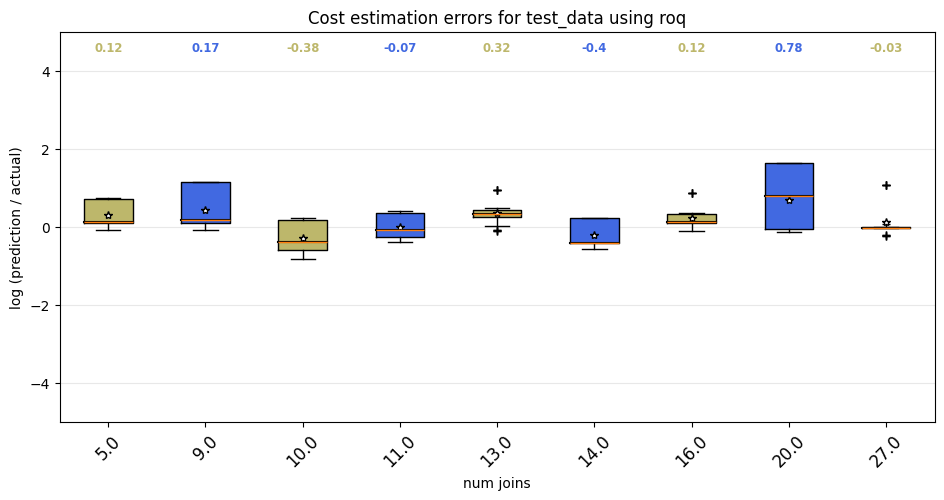

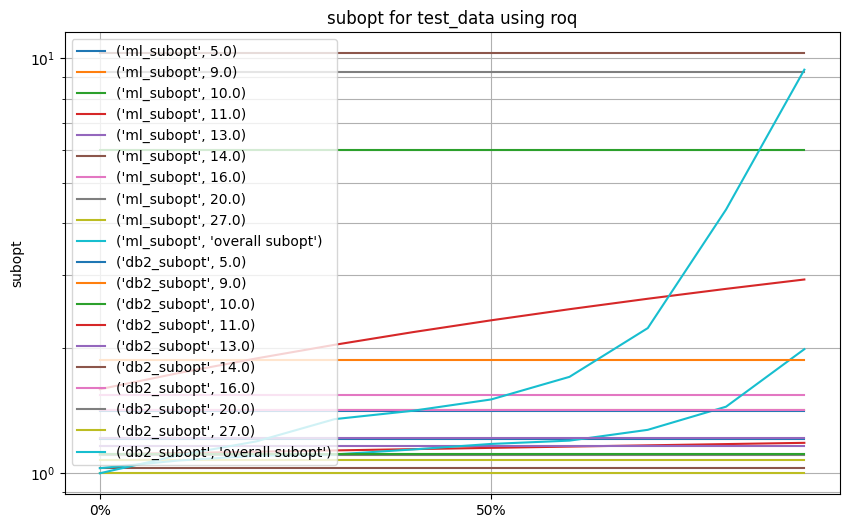

In [19]:
lero_qerror, _ = lcm_model_eval(
    test_set, ypreds_test[:,0], 
    dataset_label = 'test_data', model_label = arch
    ,load_from_disk=False, files_id = files_id,show_fig=False,
    results_dir = results_dir
)

In [20]:
ypreds_test = ypreds_test[:,0].squeeze().numpy()
targets = test_set.y.squeeze().numpy()


In [21]:
spearmanr_coef8, _ = compute_spearmanr(ypreds_test,targets)

Spearman's Rank Correlation Coefficient: 0.8002517121124337
P-value: 3.103503627886592e-59
There is a significant correlation.


In [22]:
if arch == 'lero':
    ypreds_test*=-1
    ypreds_test=1/ypreds_test

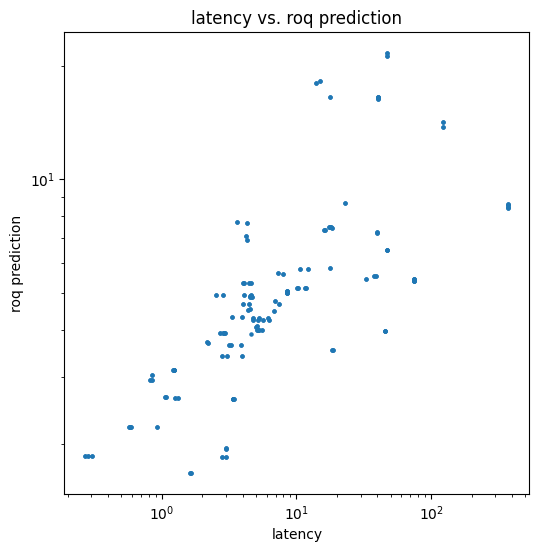

In [23]:
from util.eval_util import plotxvsy

plotxvsy(targets,ypreds_test, xl='latency', yl=f'{arch} prediction',scale='log')

In [24]:
test_qids = np.unique(np.array(test_set.query_id))
sprearmans_coef = []
for id in test_qids: 
    query_msk = (np.array(test_set.query_id) == id)
    temp, _ = compute_spearmanr(ypreds_test[query_msk],targets[query_msk], verbose=False)
    sprearmans_coef.append(temp)

In [25]:
temp, _ = compute_spearmanr(ypreds_test,targets, verbose=True)

Spearman's Rank Correlation Coefficient: 0.8002517121124337
P-value: 3.103503627886592e-59
There is a significant correlation.


In [26]:
np.array(sprearmans_coef).mean()

np.float64(0.541642111860743)

In [27]:
test_qids[8]

np.str_('33c')

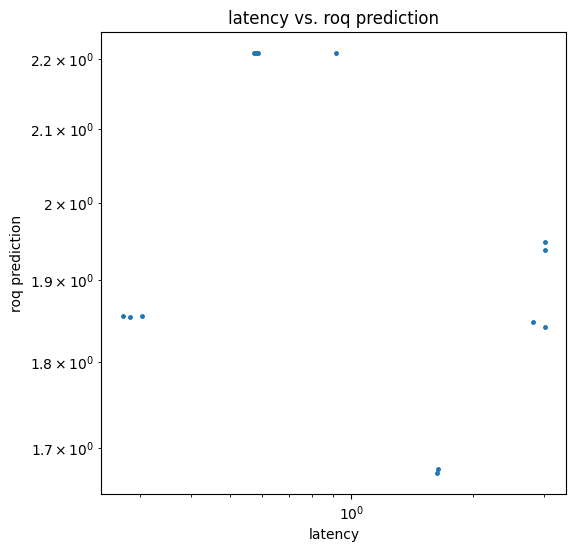

In [28]:
query_msk = (np.array(test_set.query_id) == test_qids[8])
plotxvsy(targets[query_msk],ypreds_test[query_msk], xl='latency', yl=f'{arch} prediction',scale='log')


## Deep Dive

In [29]:
from util.eval_util import plot2dhist, compute_spearmanr,lcm_model_eval

results_dir = os.path.join('..','results')

def eval(model,loader,yTransFunc):
# Validation
    ypreds = trainer.predict(model, loader)
    ypreds_arr = torch.vstack(ypreds).numpy()
    ypreds_tens_org=yTransFunc.inverse_transform(torch.Tensor(ypreds_arr))

    y_val = loader.dataset.y_t.numpy()
    plot2dhist(y_val,ypreds_arr[:,0],"y_actual","y_pred")
    spearmanr_coef4, _ = compute_spearmanr(ypreds_arr[:,0],y_val)
    
    q_error_num_joins, subopt_num_joins = lcm_model_eval(
        loader.dataset, ypreds_tens_org[:,0], 
        dataset_label = 'Test data', model_label = 'roq',
        load_from_disk=False, files_id = files_id,
        show_fig=True, results_dir=results_dir
        )
    
    return q_error_num_joins,subopt_num_joins

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 55.12it/s]


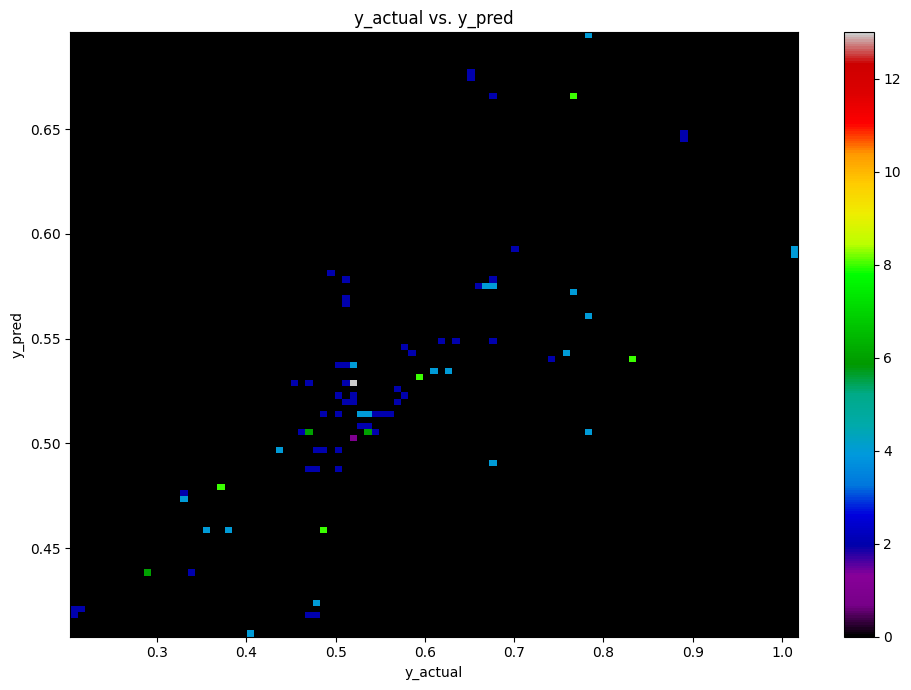

Spearman's Rank Correlation Coefficient: 0.8002517121124337
P-value: 3.103503627886592e-59
There is a significant correlation.


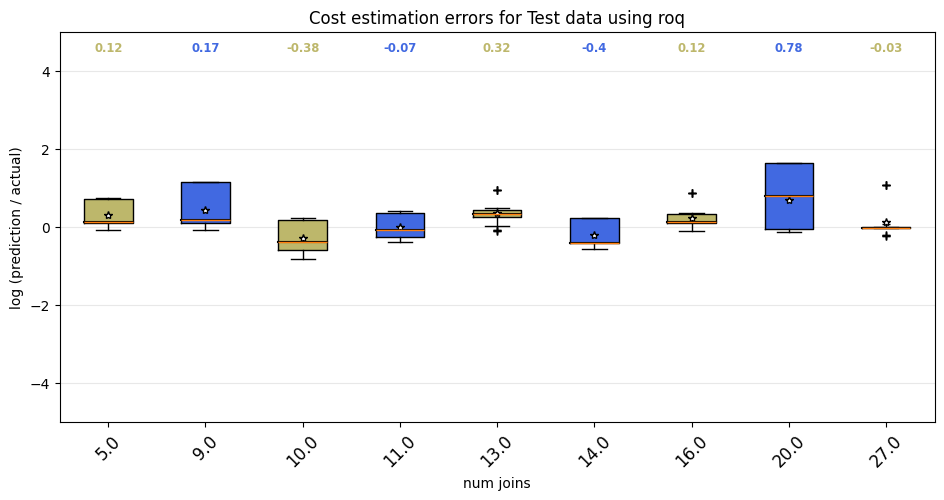

,5.0,9.0,10.0,11.0,13.0,14.0,16.0,20.0,27.0,overall q_error
count,26.000000,26.000000,26.000000,52.000000,26.000000,26.000000,26.000000,26.000000,26.000000,260.000000
mean,2.691915,5.178593,3.206473,1.852767,3.011289,2.386254,2.338624,15.643438,2.765625,4.092775
std,1.865569,5.891284,2.097943,0.520163,2.550230,0.759811,2.174260,19.383564,3.820712,7.659639
min,1.114503,1.047648,1.020666,1.054477,1.070814,1.668082,1.097218,1.154604,1.000952,1.000952
0%,1.114503,1.047648,1.020666,1.054477,1.070814,1.668082,1.097218,1.154604,1.000952,1.000952
10%,1.163303,1.120392,1.026877,1.160017,1.211457,1.668082,1.102834,1.191277,1.043683,1.081378
20%,1.211223,1.174128,1.527882,1.242767,1.283996,1.678701,1.233723,1.282681,1.055100,1.218326
30%,1.283037,1.279440,1.556448,1.370961,1.888918,1.691886,1.282658,1.309318,1.067164,1.296573
40%,1.292780,1.447659,1.641682,1.729644,1.998031,1.724104,1.293531,1.424752,1.070749,1.472512
50%,1.311843,1.481530,2.407898,1.980013,2.101890,2.530579,1.312952,6.034029,1.074959,1.691886


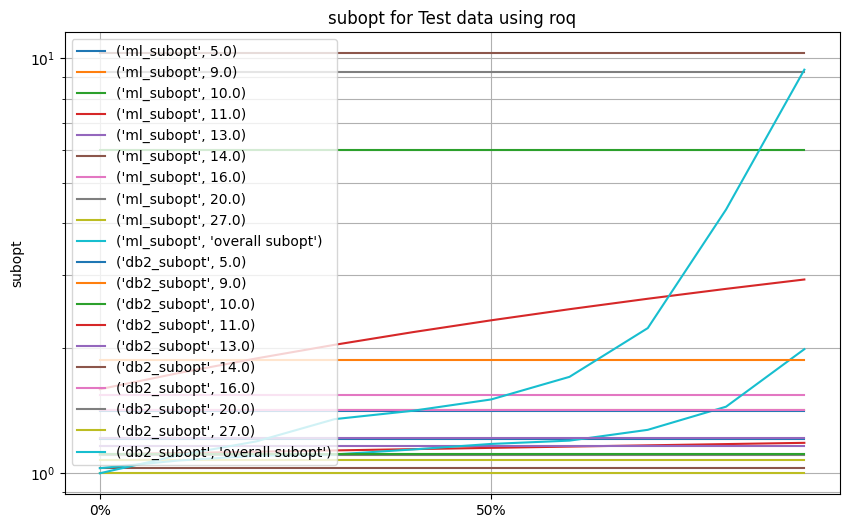

ml_subopt                                                              \
            5.0       9.0      10.0      11.0      13.0      14.0      16.0   
count  1.000000  1.000000  1.000000  2.000000  1.000000  1.000000  1.000000   
mean   1.208423  1.422548  6.005129  1.151498  1.161637  1.028561  1.545244   
std         NaN       NaN       NaN  0.057516       NaN       NaN       NaN   
min    1.208423  1.422548  6.005129  1.110828  1.161637  1.028561  1.545244   
0%     1.208423  1.422548  6.005129  1.110828  1.161637  1.028561  1.545244   
10%    1.208423  1.422548  6.005129  1.118962  1.161637  1.028561  1.545244   
20%    1.208423  1.422548  6.005129  1.127096  1.161637  1.028561  1.545244   
30%    1.208423  1.422548  6.005129  1.135230  1.161637  1.028561  1.545244   
40%    1.208423  1.422548  6.005129  1.143364  1.161637  1.028561  1.545244   
50%    1.208423  1.422548  6.005129  1.151498  1.161637  1.028561  1.545244   
60%    1.208423  1.422548  6.005129  1.159632  1.161637  1.028561  1.545244   
70%    1.208423  1.422548  6.005129  1.167766  1.161637  1.028561  1.545244   
80%    1.208423  1.422548  6.005129  1.175900  1.161637  1.028561  1.545244   
90%    1.208423  1.422548  6.005129  1.184034  1.161637  1.028561  1.545244   
max    1.208423  1.422548  6.005129  1.192168  1.161637  1.028561  1.545244   

                                         db2_subopt                      \
           20.0      27.0 overall subopt        5.0       9.0      10.0   
count  1.000000  1.000000      10.000000   1.000000  1.000000  1.000000   
mean   1.108692  1.078208       1.686144   1.409388  1.877571  1.115629   
std         NaN       NaN       1.525951        NaN       NaN       NaN   
min    1.108692  1.078208       1.028561   1.409388  1.877571  1.115629   
0%     1.108692  1.078208       1.028561   1.409388  1.877571  1.115629   
10%    1.108692  1.078208       1.073243   1.409388  1.877571  1.115629   
20%    1.108692  1.078208       1.102595   1.409388  1.877571  1.115629   
30%    1.108692  1.078208       1.110187   1.409388  1.877571  1.115629   
40%    1.108692  1.078208       1.141313   1.409388  1.877571  1.115629   
50%    1.108692  1.078208       1.176903   1.409388  1.877571  1.115629   
60%    1.108692  1.078208       1.198670   1.409388  1.877571  1.115629   
70%    1.108692  1.078208       1.272660   1.409388  1.877571  1.115629   
80%    1.108692  1.078208       1.447087   1.409388  1.877571  1.115629   
90%    1.108692  1.078208       1.991233   1.409388  1.877571  1.115629   
max    1.108692  1.078208       6.005129   1.409388  1.877571  1.115629   

                                                                              
           11.0      13.0       14.0      16.0      20.0 27.0 overall subopt  
count  2.000000  1.000000   1.000000  1.000000  1.000000  1.0      10.000000  
mean   2.337147  1.213079  10.285609  1.418315  9.290118  1.0       3.228400  
std    1.050213       NaN        NaN       NaN       NaN  NaN       3.514119  
min    1.594534  1.213079  10.285609  1.418315  9.290118  1.0       1.000000  
0%     1.594534  1.213079  10.285609  1.418315  9.290118  1.0       1.000000  
10%    1.743056  1.213079  10.285609  1.418315  9.290118  1.0       1.104066  
20%    1.891579  1.213079  10.285609  1.418315  9.290118  1.0       1.193589  
30%    2.040102  1.213079  10.285609  1.418315  9.290118  1.0       1.350495  
40%    2.188624  1.213079  10.285609  1.418315  9.290118  1.0       1.414744  
50%    2.337147  1.213079  10.285609  1.418315  9.290118  1.0       1.506424  
60%    2.485669  1.213079  10.285609  1.418315  9.290118  1.0       1.707749  
70%    2.634192  1.213079  10.285609  1.418315  9.290118  1.0       2.238228  
80%    2.782714  1.213079  10.285609  1.418315  9.290118  1.0       4.321831  
90%    2.931237  1.213079  10.285609  1.418315  9.290118  1.0       9.389667  
max    3.079760  1.213079  10.285609  1.418315  9.290118  1.0      10.285609

In [30]:
test_qerror, test_subopt =eval(model,test_loader,yTransFunc)

In [31]:
(test_subopt.ml_subopt < test_subopt.db2_subopt).sum()

np.int64(7)

In [32]:
regr_msk = (test_subopt.ml_subopt > test_subopt.db2_subopt).values
regr_msk.sum()

np.int64(3)

In [33]:
same_msk = (test_subopt.ml_subopt == test_subopt.db2_subopt).values
same_msk.sum()

np.int64(0)

In [34]:
from util.torch_scorers import subOpt2
def plot_preds_act(
        benchmark_set, ypreds_bm_m, ypreds_bm_Ud, ypreds_bm_Um,
        msk = regr_msk, idx = 10,q_id=None
        ):
    query_ids = np.unique(np.array(benchmark_set.query_id))
    
    if idx is not None:
        q_id = query_ids[msk][idx]

    q_msk = (np.array(benchmark_set.query_id) == q_id)
    print(q_id)

    actuals = benchmark_set[q_msk].y
    costs = benchmark_set[q_msk].opt_cost
    preds = torch.tensor(ypreds_bm_m[q_msk])
    ml_subopt, db2_subopt = subOpt2(actuals, preds, costs)
    print("ml subopt: {:.4f}, db2 subopt: {:.4f}".format(ml_subopt,db2_subopt))

    x=benchmark_set.y_t[q_msk].numpy()
    y=ypreds_bm_m[q_msk]
    err=ypreds_bm_Ud[q_msk]
    xerr=ypreds_bm_Um[q_msk]
    plotxvsy(x, y,xerr=xerr, err=err, xl="actual", yl="pred")

In [35]:
from util.eval_util import plotxvsy
from util.torch_scorers import subOpt2
def plot_preds_act(
        benchmark_set, ypreds_bm_m, ypreds_bm_Ud, ypreds_bm_Um,
        msk = regr_msk, idx = 10,q_id=None
        ):
    query_ids = np.unique(np.array(benchmark_set.query_id))
    
    if idx is not None:
        q_id = query_ids[msk][idx]

    q_msk = (np.array(benchmark_set.query_id) == q_id)
    print(q_id)

    actuals = benchmark_set[q_msk].y
    costs = benchmark_set[q_msk].opt_cost
    preds = torch.tensor(ypreds_bm_m[q_msk])
    ml_subopt, db2_subopt = subOpt2(actuals, preds, costs)
    print("ml subopt: {:.4f}, db2 subopt: {:.4f}".format(ml_subopt,db2_subopt))

    x=benchmark_set.y_t[q_msk].numpy()
    y=ypreds_bm_m[q_msk]
    err=ypreds_bm_Ud[q_msk]
    xerr=ypreds_bm_Um[q_msk]
    plotxvsy(x, y,xerr=xerr, err=err, xl="actual", yl="pred")

In [36]:
# Enables variational inference using MC dropout
from util.torch_util import LitMCdropoutModel

LitMCDPModel = LitMCdropoutModel(
    model, mc_iteration=10, 
    dropout=config['dropout']
    )

In [37]:
# Test
ypreds_test_ = trainer.predict(model, test_loader)
ypreds_arr_test = torch.vstack(ypreds_test_).numpy()
ypreds_tens_test_org=yTransFunc.inverse_transform(torch.Tensor(ypreds_arr_test))

ypreds_test_mc = trainer.predict(LitMCDPModel, test_loader)
ypreds_test_mc = torch.hstack([torch.Tensor(ypreds_test_mc[b]) for b in range(len(ypreds_test_mc))])

ypreds_test_m, ypreds_test_Ud, ypreds_test_Um = comput_uncertainty(ypreds_test_mc)
ypreds_test_m_org=yTransFunc.inverse_transform(torch.Tensor(ypreds_test_m))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 37.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]


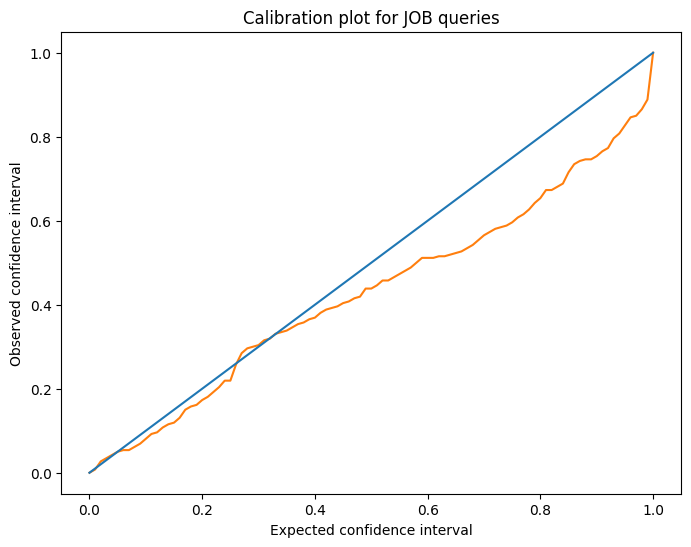

In [38]:
from util.eval_util import evalCalib

evalCalib(ypreds_test_m,ypreds_test_Ud,
          test_set.y_t.numpy(),
          title='JOB queries')

In [1]:
test_qids[0]

NameError: name 'test_qids' is not defined

19d
ml subopt: 1.1616, db2 subopt: 1.2131


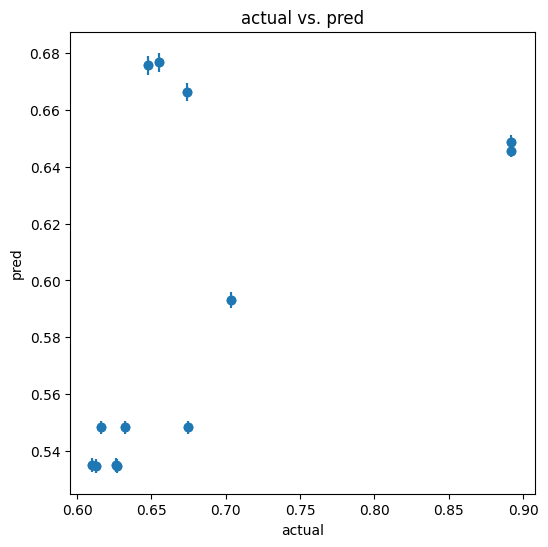

In [40]:
plot_preds_act(
    test_set, ypreds_arr_test[:,0], 
    ypreds_arr_test[:,1],ypreds_test_Um,
    msk = regr_msk, idx = None, q_id = test_qids[4]
    )

In [41]:
from util.eval_util import evaluate_method

risk_subopts,risk_runtimes,best_runtimes,subopt_risk,_ = evaluate_method(
    ypreds_test_m, ypreds_test_Ud, test_set, strategy = 'subopt risk',
    return_targets=True
    )

subopt risk  : spearman's corr : (np.float64(0.4225596701507782), np.float64(1.1039742221877095e-12))
queries with no plans after pruning: 0
evaluation time: 0.018964529037475586



33c
ml subopt: 2.1680, db2 subopt: 1.1156


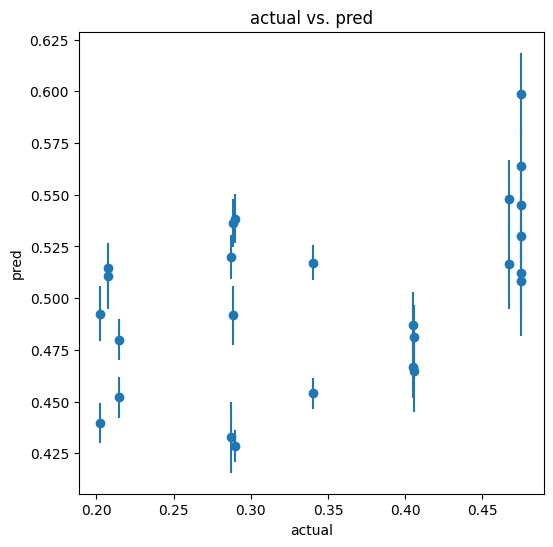

In [42]:
plot_preds_act(
    test_set, subopt_risk, 
    ypreds_test_Ud, ypreds_test_Um,
    msk = regr_msk, idx = None, q_id = '33c'
    )

In [43]:
strategy_args = {'prune_ratio': 0.3}

risk_subopts_prune,risk_runtimes_prune,_,subopt_risk_prune,prune_msk= evaluate_method(
    ypreds_test_m, ypreds_test_Ud, test_set, strategy = 'subopt risk',
    return_targets=True, prune=True, **strategy_args
    )

subopt risk prune : spearman's corr : (np.float64(0.2536824782791355), np.float64(0.0005899760078280171))
queries with no plans after pruning: 0
evaluation time: 0.006646394729614258



In [44]:
sort_id = np.argsort(np.array(test_set.query_id))
y_ud_sort = ypreds_test_Ud[sort_id]
y_um_sort = ypreds_test_Um[sort_id]
test_set_sort = test_set[sort_id]

31c
ml subopt: 92.9012, db2 subopt: 9.2901


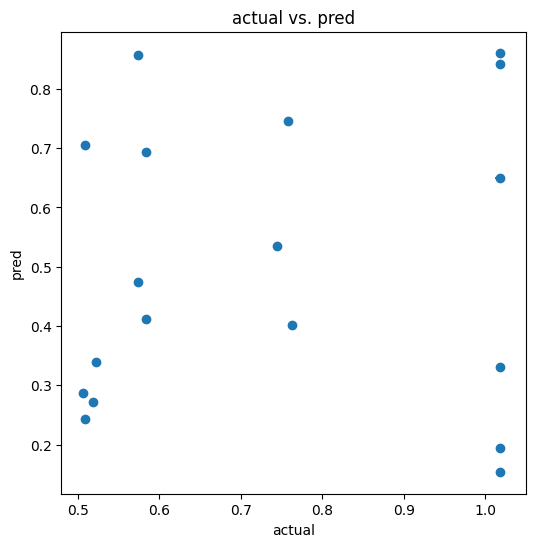

In [45]:
plot_preds_act(
    test_set_sort[prune_msk], subopt_risk_prune, y_ud_sort[prune_msk], y_um_sort[prune_msk],
    msk = regr_msk, idx = None, q_id = '31c'
    )